**Analiza danych na temat mieszkań z rybku wtórnego na sprzedaż w Warszawie z dnia 20 maja 2024.**

Na początku wczytujemy dane oraz kowertujemy odpowiednio kolumny, tak aby późniejsza analiza była przyjemniejsza.

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import locale

#ustawienie lokalizacji na polską
try:
    locale.setlocale(locale.LC_ALL, 'pl_PL.UTF-8')
except locale.Error:
    locale.setlocale(locale.LC_ALL, 'pl_PL')

df = pd.read_excel("cleaned_data.xlsx")

#konwersja ceny na liczby zmiennoprzecinkowe z uwzględnieniem formatu waluty
def parse_price(price):
    try:
        return locale.atof(price.replace(' PLN', '')) if isinstance(price, str) else price
    except ValueError:
        return float('nan')

df['Price'] = df['Price'].apply(parse_price)
df['Price per m2'] = df['Price per m2'].apply(parse_price)

#funkcje do formatowania ceny - do osi wykresów
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

#separator kwot na osi
def millions(x, pos):
    'The two args are the value and tick position'
    return '{:,.0f}'.format(x).replace(',', ' ')

print(df.head())


                      Street      Urban area        District     m2  Rooms  \
0                ul. Osowska         Grochów  Praga-Południe  52.30      2   
1  ul. Wacława Sierpińskiego        Rakowiec          Ochota  33.30      1   
2               ul. Dymińska  Stary Żoliborz        Żoliborz  37.00      2   
3               ul. Narwik 8           Górce          Bemowo  58.50      2   
4     ul. Józefa Szanajcy 11      Nowa Praga    Praga-Północ  36.21      2   

   Floor   Price  Price per m2 Currency          Seller type  \
0      2  799000       15277.0      PLN  Biuro nieruchomości   
1      2  670000       20120.0      PLN      Oferta prywatna   
2      4  669000       18081.0      PLN      Oferta prywatna   
3      4  970000       16581.0      PLN      Oferta prywatna   
4      2  720000       19884.0      PLN      Oferta prywatna   

            Estate agency  
0  SZCZĘSNY NIERUCHOMOŚCI  
1                     NaN  
2                     NaN  
3                     NaN  
4     

Jako pierwszą rzecz chcemy zobaczyć ogólny rozkład cen mieszkań z rynku wtórnego w Warszawie.

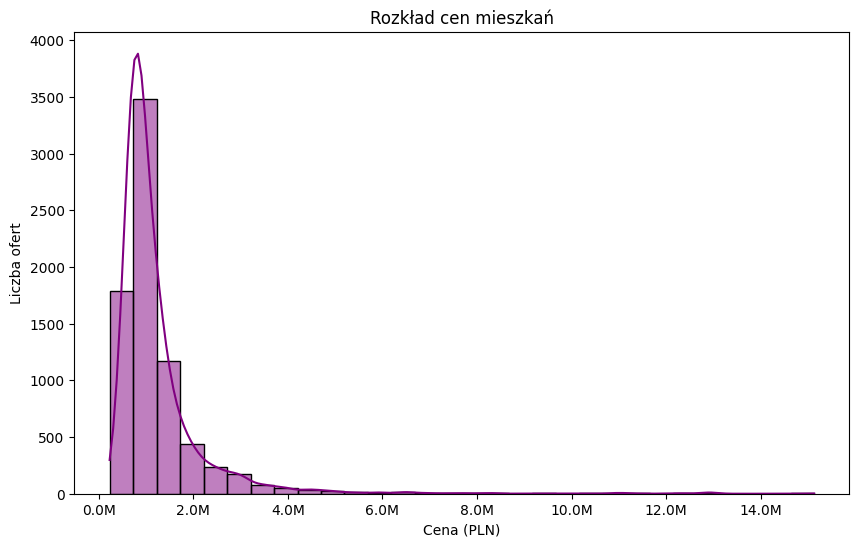

In [102]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True, color='purple')
plt.title('Rozkład cen mieszkań')
plt.xlabel('Cena (PLN)')
plt.ylabel('Liczba ofert')
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.show()

Kolejną istotną kwestią, którą zbadamy jest zależność pomiędzy ceną, a metrażem mieszkania.

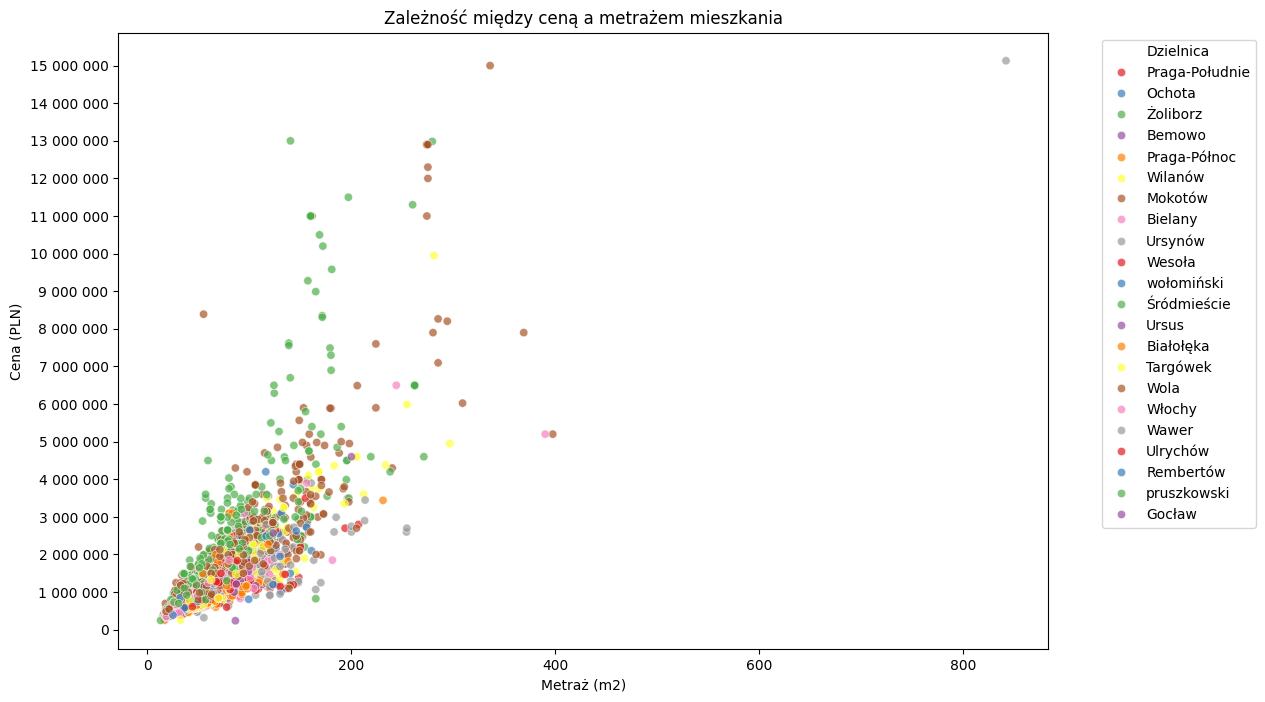

In [158]:
filtered_districts = df[df['District'] != 'Warszawa']
offers_per_district = filtered_districts['District'].value_counts()

plt.figure(figsize=(12, 8))
sns.scatterplot(x='m2', y='Price', data=filtered_districts, hue='District', palette='Set1', alpha=0.7)
plt.title('Zależność między ceną a metrażem mieszkania')
plt.xlabel('Metraż (m2)')
plt.ylabel('Cena (PLN)')
plt.legend(title='Dzielnica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1000000))
plt.show()

Idąc dalej, przeanalizujmy jak wygląda rozkład cen mieszkań w poszczególnych dzielnicach.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_25472\2044910369.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='District', y='Price', data=filtered_districts, palette='coolwarm_r')


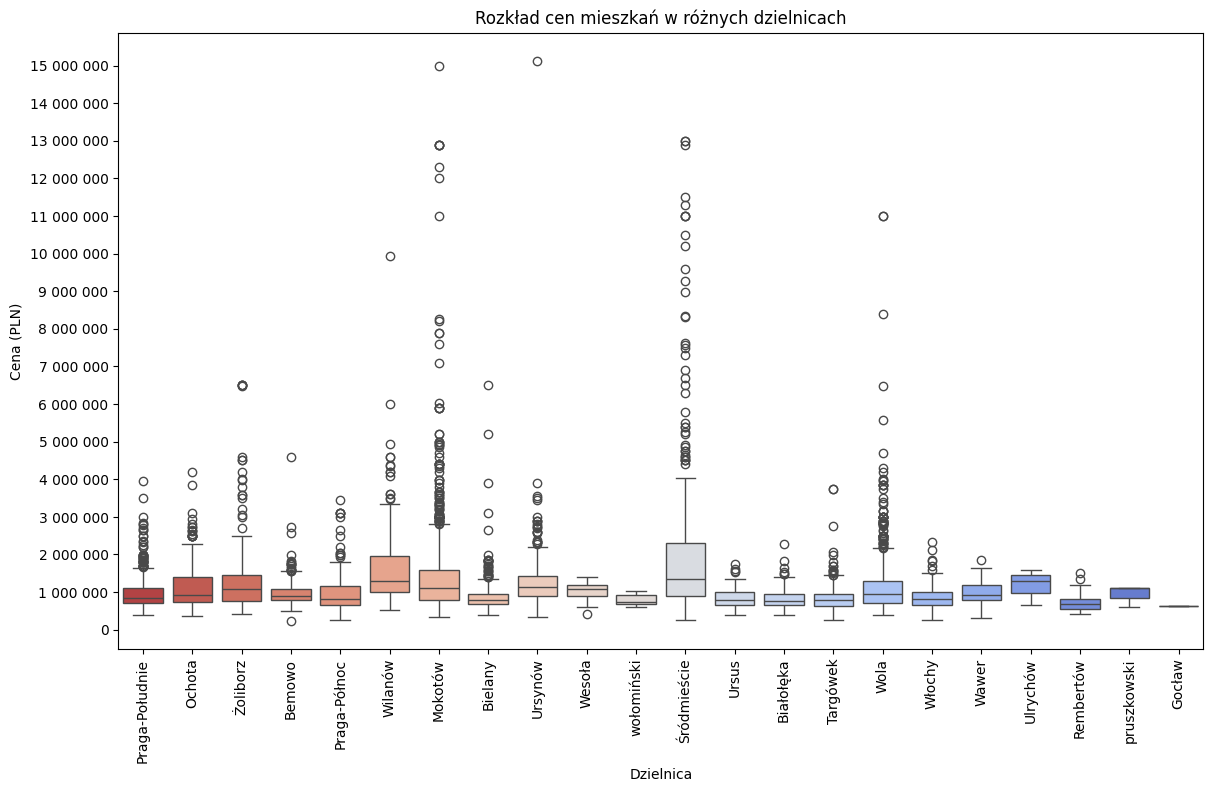

In [160]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='District', y='Price', data=filtered_districts, palette='coolwarm_r')
plt.title('Rozkład cen mieszkań w różnych dzielnicach')
plt.xlabel('Dzielnica')
plt.ylabel('Cena (PLN)')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1000000))
plt.show()

Następnie zbadamy zalezność pomiędzy średnią ceną za m2 mieszkania, a dzielnicą, w jakiej się ono znajduje.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_25472\2589900908.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_price_per_m2.index, y=mean_price_per_m2.values, palette='coolwarm_r')


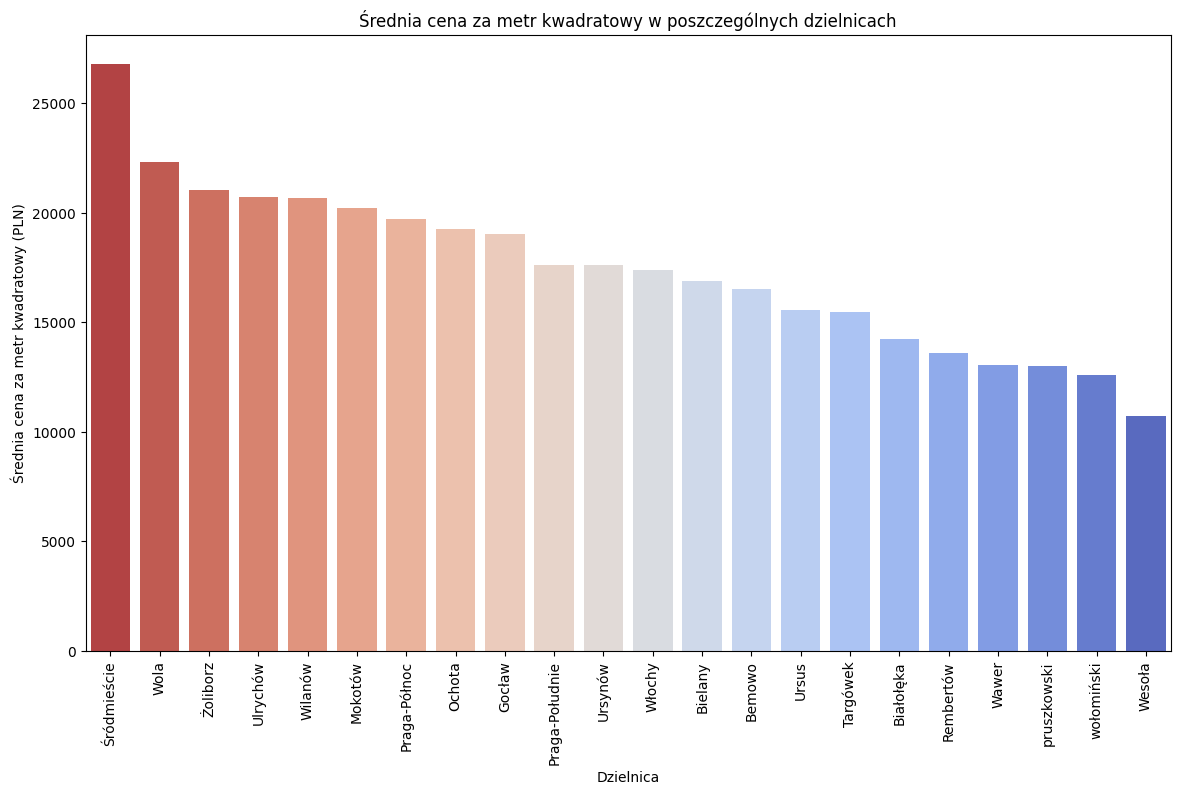

In [163]:
mean_price_per_m2 = filtered_districts.groupby('District')['Price per m2'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=mean_price_per_m2.index, y=mean_price_per_m2.values, palette='coolwarm_r')
plt.title('Średnia cena za metr kwadratowy w poszczególnych dzielnicach')
plt.xlabel('Dzielnica')
plt.ylabel('Średnia cena za metr kwadratowy (PLN)')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5000))
plt.show()


Poniżej przedstawiamy podział ofert ze względu na rodzaj sprzedawcy.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_25472\3525368534.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seller_counts.index, y=seller_counts.values, palette='viridis_r')


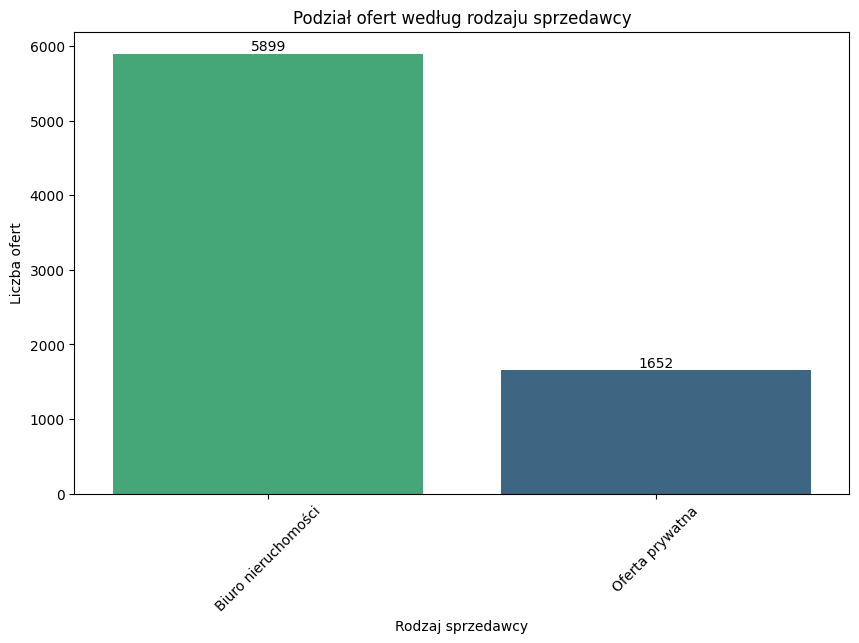

In [106]:
seller_counts = df['Seller type'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=seller_counts.index, y=seller_counts.values, palette='viridis_r')
plt.title('Podział ofert według rodzaju sprzedawcy')
plt.xlabel('Rodzaj sprzedawcy')
plt.ylabel('Liczba ofert')
plt.xticks(rotation=45)
for index, value in enumerate(seller_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.show()

Skoro już wiemy, że większością opublikowanych ofert zajmuje się biuro nieruchomości, sprawdźmy zatem jak wpływa to na cenę wystawianych mieszkań.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_25472\3959640435.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_price_seller.index, y=mean_price_seller.values, palette='pastel')


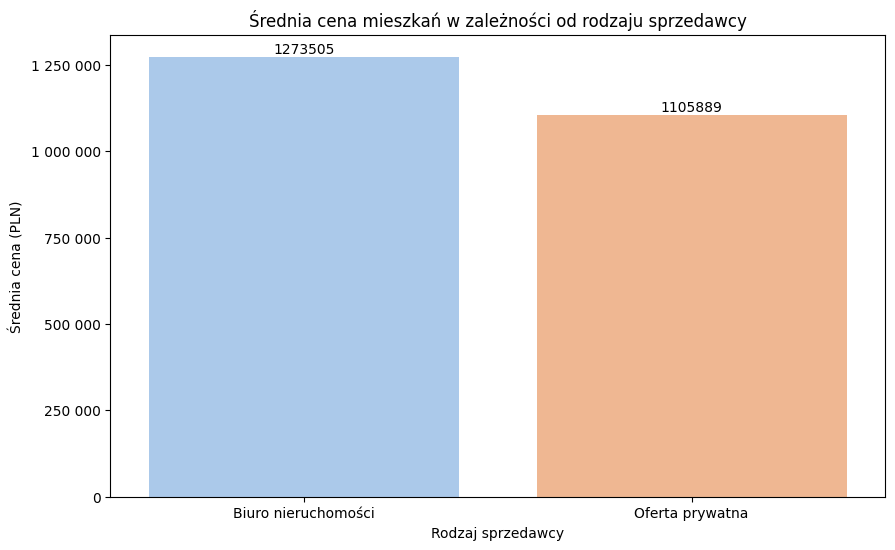

In [164]:
mean_price_seller = df.groupby('Seller type')['Price'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_price_seller.index, y=mean_price_seller.values, palette='pastel')
plt.title('Średnia cena mieszkań w zależności od rodzaju sprzedawcy')
plt.xlabel('Rodzaj sprzedawcy')
plt.ylabel('Średnia cena (PLN)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
for index, value in enumerate(mean_price_seller.values):
    plt.text(index, value, str(int(value)), ha='center', va='bottom')
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(250000))
plt.show()

Rozkład liczby pokoi.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_25472\518593902.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rooms', data=df, palette='pastel')


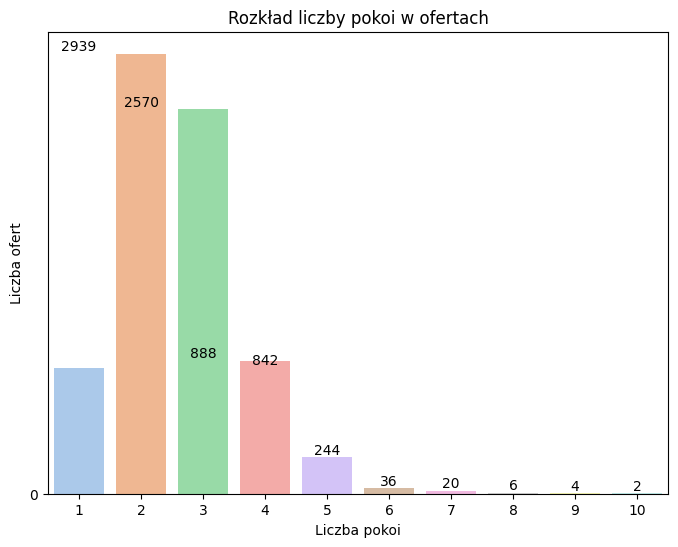

In [165]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Rooms', data=df, palette='pastel')
plt.title('Rozkład liczby pokoi w ofertach')
plt.xlabel('Liczba pokoi')
plt.ylabel('Liczba ofert')
for index, value in enumerate(df['Rooms'].value_counts().values):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(250000))
plt.show()

A teraz zbadamy jak ilość pokoi w mieszkaniu determinuję cenę nieruchomości.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_25472\1276459194.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_price_rooms.index, y=mean_price_rooms.values, palette='viridis_r')


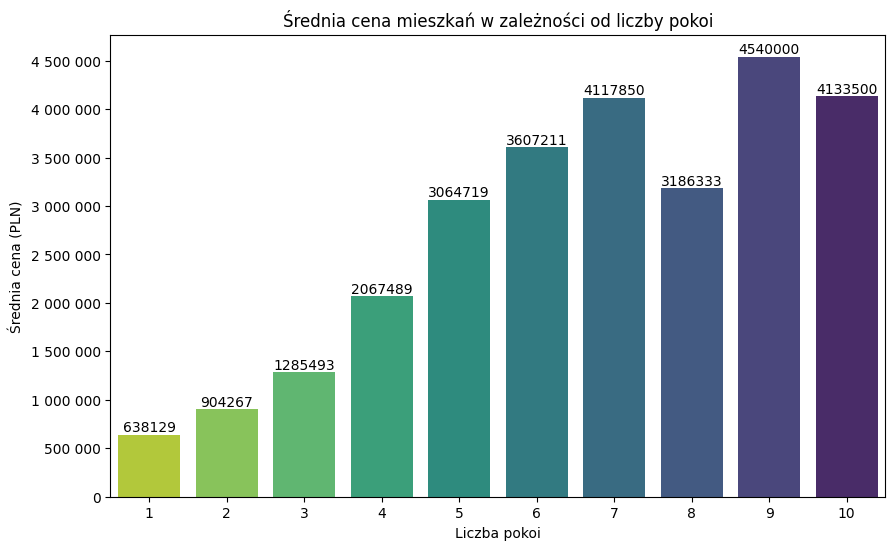

In [156]:
mean_price_rooms = df.groupby('Rooms')['Price'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_price_rooms.index, y=mean_price_rooms.values, palette='viridis_r')
plt.title('Średnia cena mieszkań w zależności od liczby pokoi')
plt.xlabel('Liczba pokoi')
plt.ylabel('Średnia cena (PLN)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500000)) 
for index, value in enumerate(mean_price_rooms.values):
    plt.text(index, value, str(int(value)), ha='center', va='bottom')
plt.show()


Oraz zobaczymy jak metraż mieszkania wpływa na liczbę pokoi.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_25472\1413612602.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='Rooms', y='m2', data=filtered_districts, palette='Set1', marker='o')


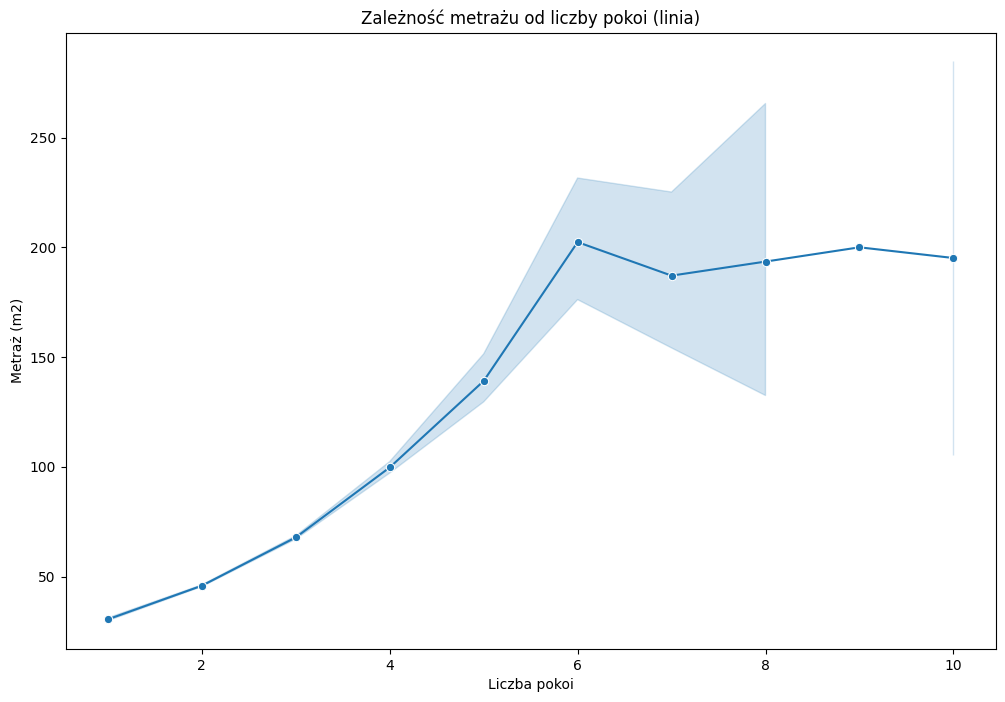

In [141]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='Rooms', y='m2', data=filtered_districts, palette='Set1', marker='o')
plt.title('Zależność metrażu od liczby pokoi (linia)')
plt.xlabel('Liczba pokoi')
plt.ylabel('Metraż (m2)')
plt.show()


W poszczególnych dzielnicach.

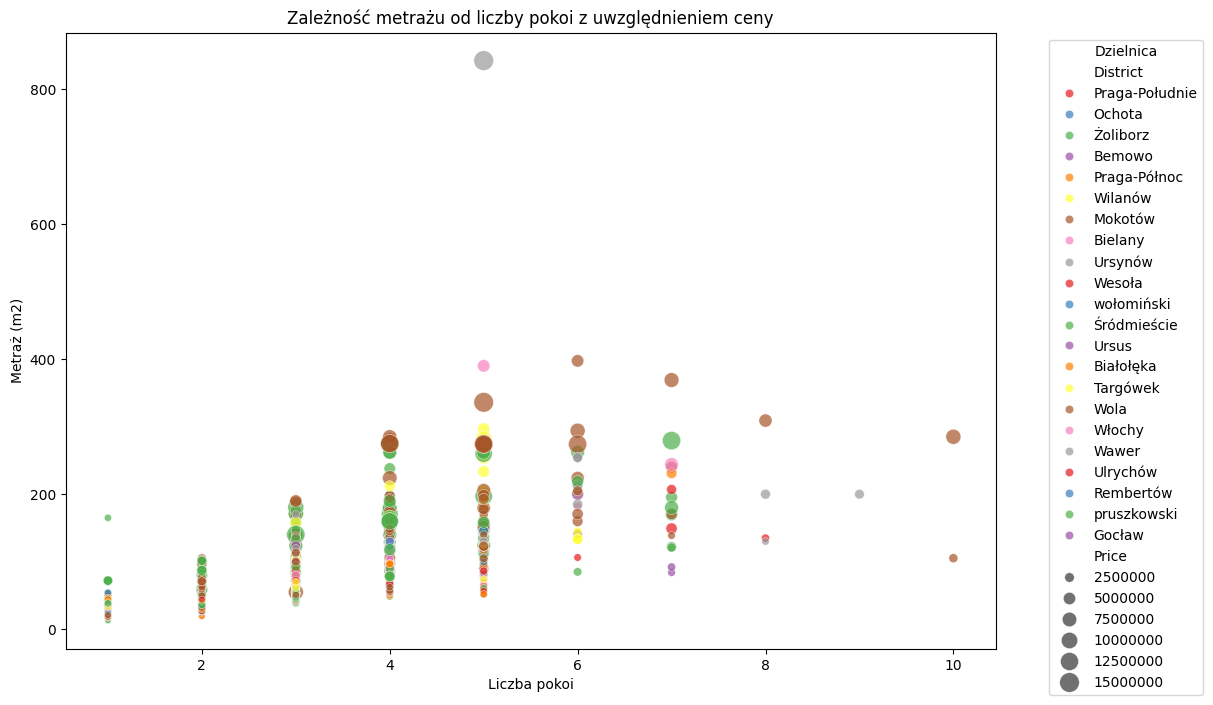

In [140]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Rooms', y='m2', data=filtered_districts, hue='District', palette='Set1', alpha=0.7, size='Price', sizes=(20, 200))
plt.title('Zależność metrażu od liczby pokoi z uwzględnieniem ceny')
plt.xlabel('Liczba pokoi')
plt.ylabel('Metraż (m2)')
plt.legend(title='Dzielnica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


A teraz sprawdźmy jak ilośc pokoi wpływa na cenę mieszkania.

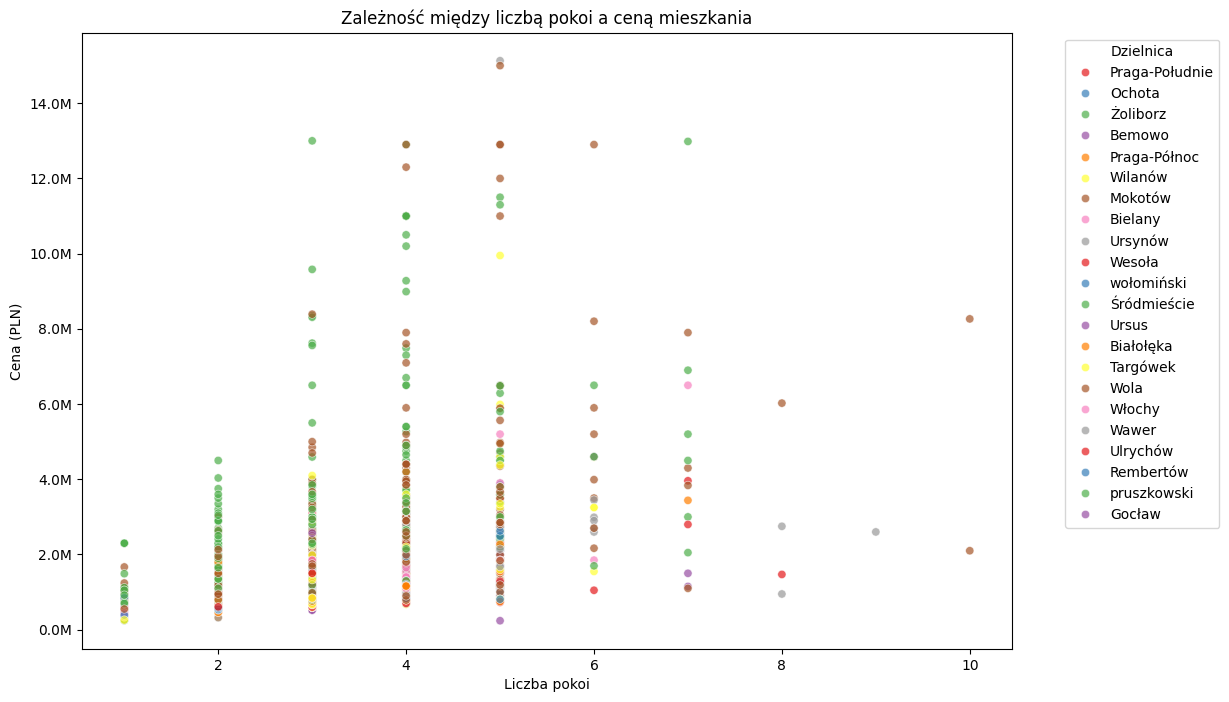

In [133]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Rooms', y='Price', data=filtered_districts, hue='District', palette='Set1', alpha=0.7)
plt.title('Zależność między liczbą pokoi a ceną mieszkania')
plt.xlabel('Liczba pokoi')
plt.ylabel('Cena (PLN)')
plt.legend(title='Dzielnica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.show()

Poniżej analizujemy liczbę ofert w poszczególnych dzielnicach.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_25472\1407204839.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=offers_per_district.index, y=offers_per_district.values, palette='viridis_r')


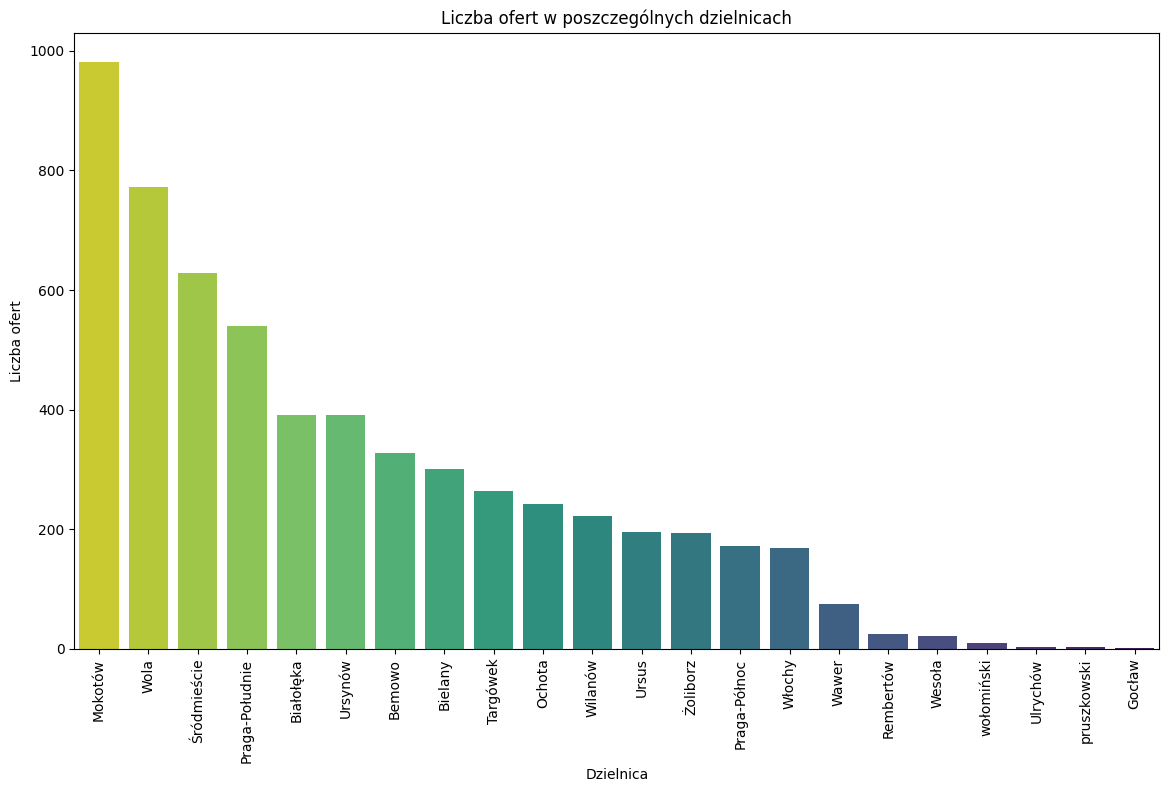

In [130]:
plt.figure(figsize=(14, 8))
sns.barplot(x=offers_per_district.index, y=offers_per_district.values, palette='viridis_r')
plt.title('Liczba ofert w poszczególnych dzielnicach')
plt.xlabel('Dzielnica')
plt.ylabel('Liczba ofert')
plt.xticks(rotation=90)
plt.show()


Interesującą kwestią również jest ilość ofert w poszczególnych dzielnicach.

C:\Users\sylwi\AppData\Local\Temp\ipykernel_25472\3772717410.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=offers_per_district.index, y=offers_per_district.values, palette='viridis_r')


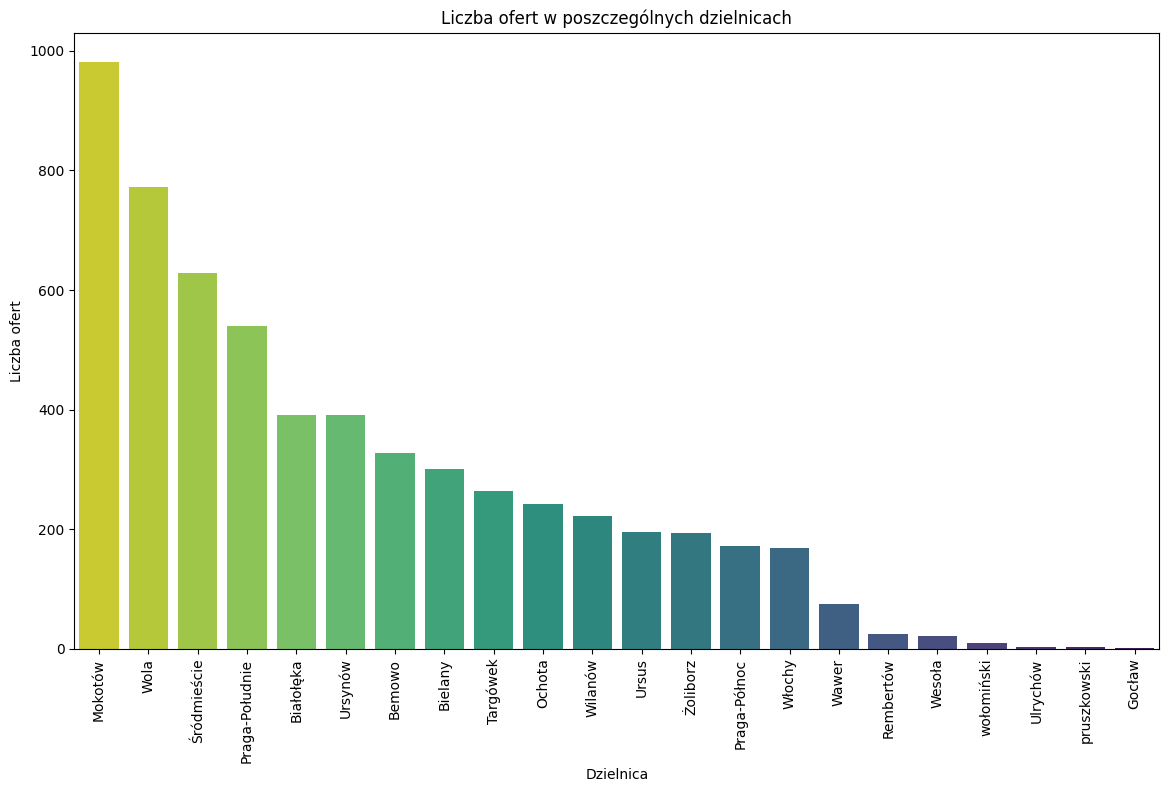

In [150]:
filtered_districts = df[df['District'] != 'Warszawa']
offers_per_district = filtered_districts['District'].value_counts()
plt.figure(figsize=(14, 8))
sns.barplot(x=offers_per_district.index, y=offers_per_district.values, palette='viridis_r')
plt.title('Liczba ofert w poszczególnych dzielnicach')
plt.xlabel('Dzielnica')
plt.ylabel('Liczba ofert')
plt.xticks(rotation=90)
plt.show()